In [1]:
import cv2 as cv
import glob
import numpy as np
import matplotlib.pyplot as plt

In [24]:
def calibrate_camera(images_folder):
    images_names = glob.glob(images_folder)
    print(images_names)
    images = []
    for imname in images_names:
        im = cv.imread(imname, 1)
        images.append(im)

    #criteria used by checkerboard pattern detector.
    #Change this if the code can't find the checkerboard
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
 
    rows = 6 #number of checkerboard rows.
    columns = 8 #number of checkerboard columns.
    world_scaling = 90.7 #mm #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 
    #frame dimensions. Frames should be the same size.
    width = images[0].shape[1]
    height = images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints = [] # 2d points in image plane.
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
 
 
    for frame in images:
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        # plt.imshow(gray, cmap='gray')
        # plt.show()
 
        #find the checkerboard
        ret, corners = cv.findChessboardCorners(gray, (rows, columns), None)
        print(ret)
 
        if ret == True:
 
            #Convolution size used to improve corner detection. Don't make this too large.
            conv_size = (11, 11)
 
            #opencv can attempt to improve the checkerboard coordinates
            corners = cv.cornerSubPix(gray, corners, conv_size, (-1, -1), criteria)
            cv.drawChessboardCorners(frame, (rows,columns), corners, ret)
            plt.imshow(frame, cmap='gray')
            plt.show()
 
            objpoints.append(objp)
            imgpoints.append(corners)
 
 
 
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, (width, height), None, None)
    print('rmse:', ret)
    print('camera matrix:\n', mtx)
    print('distortion coeffs:', dist)
    print('Rs:\n', rvecs)
    print('Ts:\n', tvecs)
 
    return mtx, dist

In [25]:
def stereo_calibrate(mtx1, dist1, mtx2, dist2, frames_folder1, frames_folder2):
    #read the synched frames
    images_names1 = glob.glob(frames_folder1)
    images_names2 = glob.glob(frames_folder2)
    c1_images_names = sorted(images_names1)
    c2_images_names = sorted(images_names1)

    print(c1_images_names)
    print(c2_images_names)
    c1_images = []
    c2_images = []
    for im1, im2 in zip(c1_images_names, c2_images_names):
        _im = cv.imread(im1, 1)
        c1_images.append(_im)
 
        _im = cv.imread(im2, 1)
        c2_images.append(_im)

 
    #change this if stereo calibration not good.
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
 
    rows = 6 #number of checkerboard rows.
    columns = 9 #number of checkerboard columns.
    world_scaling = 90.7 #change this to the real world square size. Or not.
 
    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp
 
    #frame dimensions. Frames should be the same size.
    width = c1_images[0].shape[1]
    height = c1_images[0].shape[0]
 
    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []
 
    #coordinates of the checkerboard in checkerboard world space.
    objpoints = [] # 3d point in real world space
 
    for frame1, frame2 in zip(c1_images, c2_images):

        gray1 = cv.cvtColor(frame1, cv.COLOR_BGR2GRAY)
        gray2 = cv.cvtColor(frame2, cv.COLOR_BGR2GRAY)
        c_ret1, corners1 = cv.findChessboardCorners(gray1, (6, 9), None)
        print(c_ret1)
        c_ret2, corners2 = cv.findChessboardCorners(gray2, (6, 9), None)
        print(c_ret2)
        
        if c_ret1 == True and c_ret2 == True:
            corners1 = cv.cornerSubPix(gray1, corners1, (11, 11), (-1, -1), criteria)
            corners2 = cv.cornerSubPix(gray2, corners2, (11, 11), (-1, -1), criteria)
 
            cv.drawChessboardCorners(frame1, (6,9), corners1, c_ret1)
            plt.imshow(frame1, cmap='gray')
            plt.show()
 
            cv.drawChessboardCorners(frame2, (6,9), corners2, c_ret2)
            
 
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)
 
    stereocalibration_flags = cv.CALIB_FIX_INTRINSIC
    ret, CM1, dist1, CM2, dist2, R, T, E, F = cv.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx1, dist1,
                                                                 mtx2, dist2, (width, height), criteria = criteria, flags = stereocalibration_flags)
 
    print(ret)
    return R, T

['cam1\\0.jpeg', 'cam1\\1.jpeg', 'cam1\\10.jpeg', 'cam1\\11.jpeg', 'cam1\\2.jpeg', 'cam1\\3.jpeg', 'cam1\\4.jpeg', 'cam1\\5.jpeg', 'cam1\\6.jpeg', 'cam1\\7.jpeg', 'cam1\\8.jpeg', 'cam1\\9.jpeg']
True


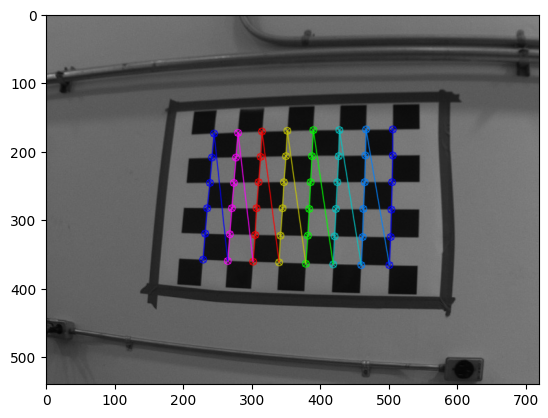

True


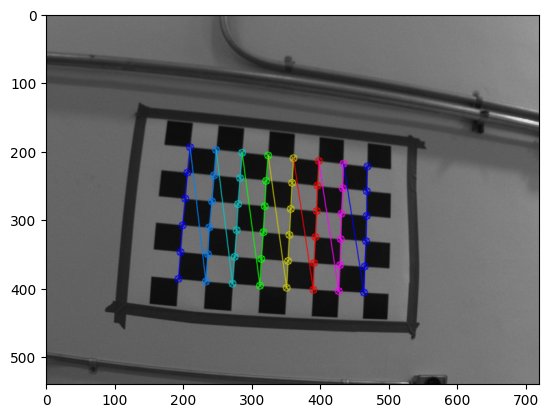

True


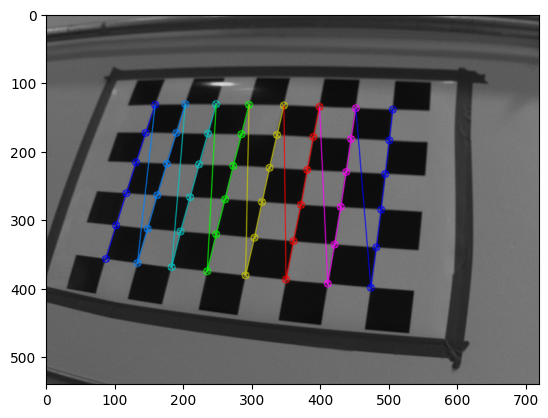

True


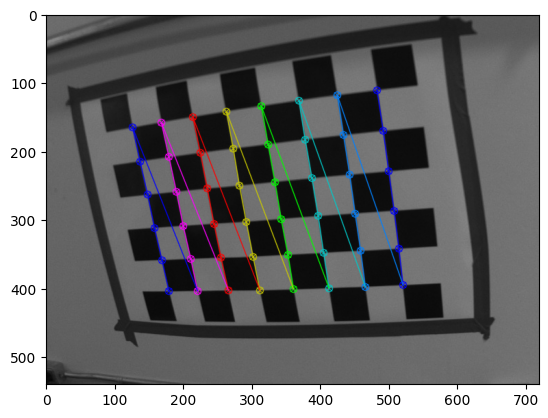

True


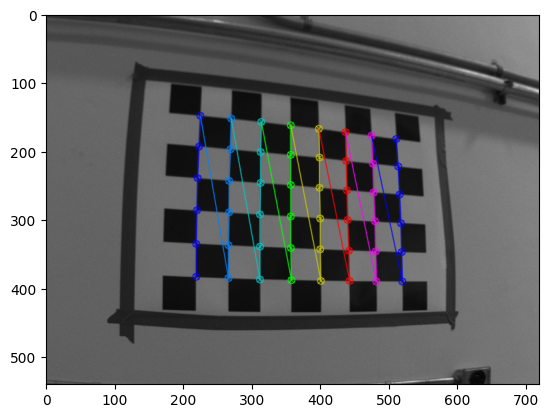

False
False
True


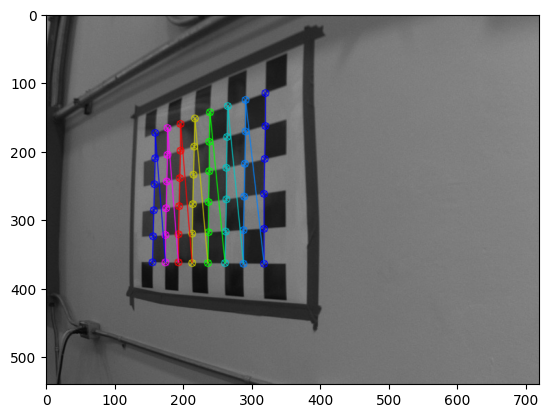

False
True


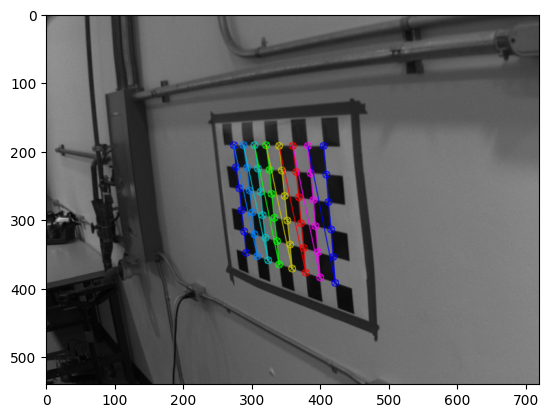

False
True


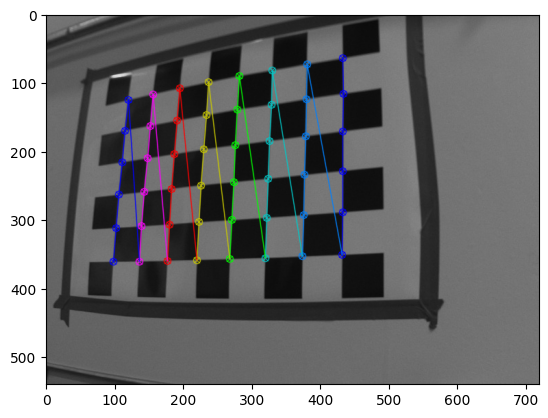

rmse: 0.37804302568876014
camera matrix:
 [[886.69249058   0.         355.49716285]
 [  0.         885.10699206 298.63702074]
 [  0.           0.           1.        ]]
distortion coeffs: [[-4.47187297e-01 -1.45060603e-02 -3.96069736e-03  6.10024606e-04
   4.67257412e+00]]
Rs:
 (array([[0.05953855],
       [0.35324552],
       [1.5928469 ]]), array([[-0.00322116],
       [-0.3058391 ],
       [-1.48763867]]), array([[-0.52921379],
       [-0.15418045],
       [-1.40564318]]), array([[0.49038515],
       [0.05518207],
       [1.42162062]]), array([[ 0.1445911 ],
       [-0.41836456],
       [-1.52148025]]), array([[0.62687377],
       [0.73398154],
       [1.43071561]]), array([[-0.6155497 ],
       [ 0.970381  ],
       [-1.40772063]]), array([[0.1936989 ],
       [0.50378629],
       [1.51962744]]))
Ts:
 (array([[ 342.86782771],
       [-297.44752201],
       [1974.4280452 ]]), array([[-365.10793384],
       [ 198.21669025],
       [1952.3795498 ]]), array([[-444.20376407],
       [  

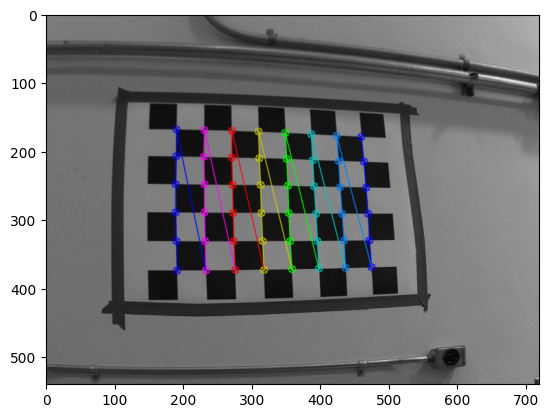

True


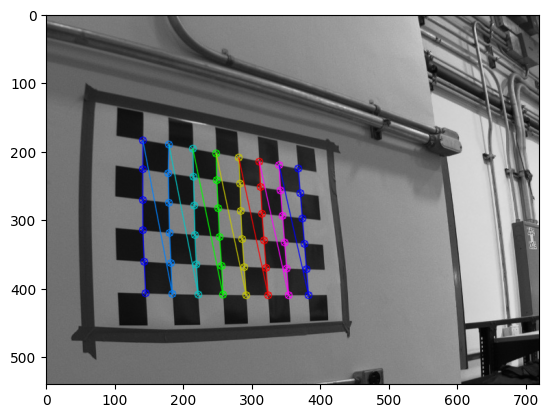

True


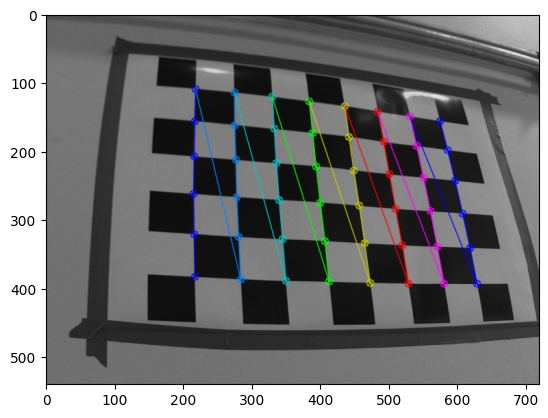

True


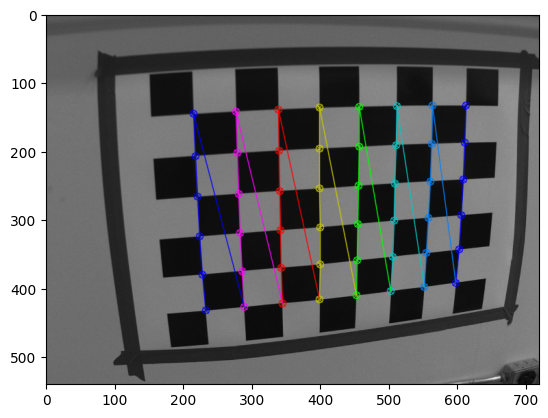

False
False
True


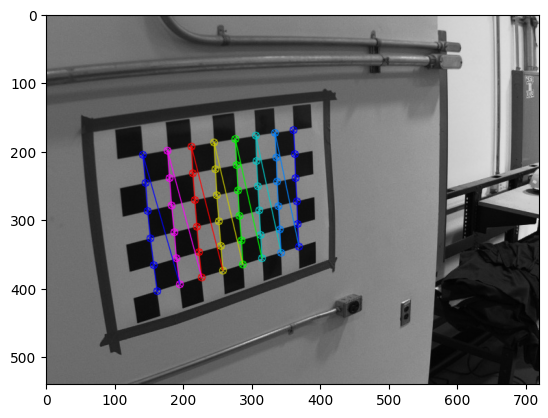

True


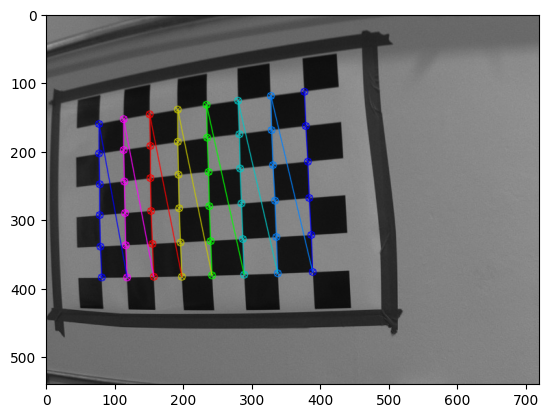

True


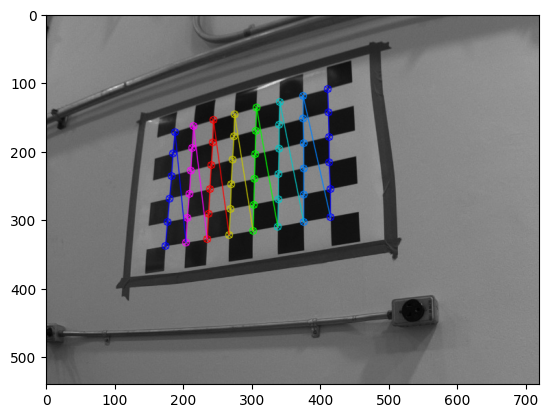

True


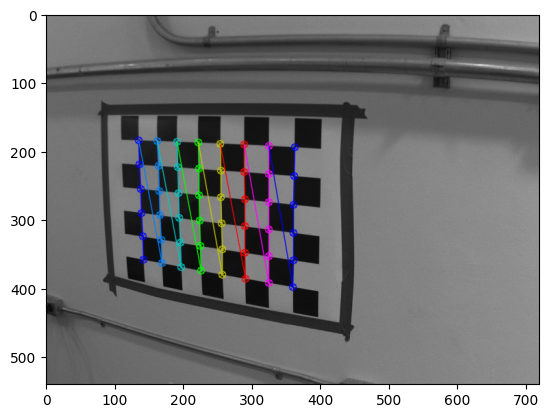

True


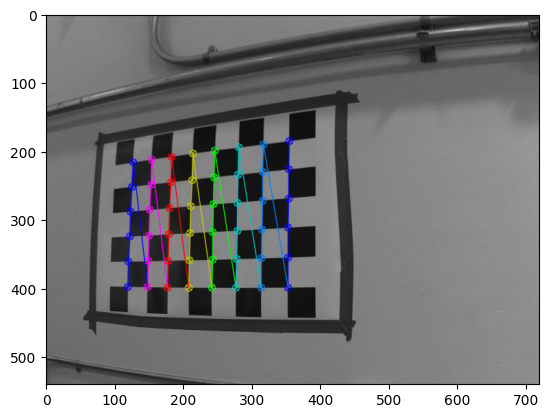

True


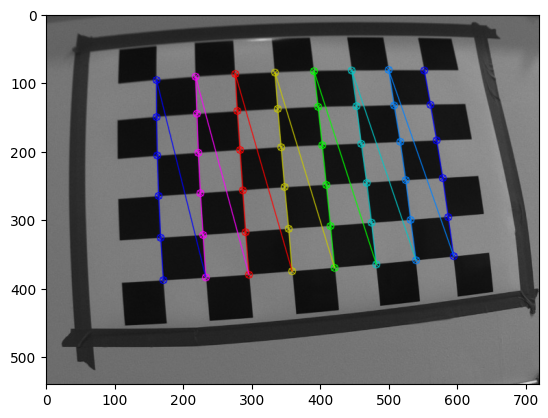

rmse: 0.3477860493247679
camera matrix:
 [[887.10558925   0.         383.23044703]
 [  0.         884.77438999 288.78380647]
 [  0.           0.           1.        ]]
distortion coeffs: [[-3.93214858e-01 -4.22821977e-01  2.44919519e-04 -1.47322185e-04
   3.09200664e+00]]
Rs:
 (array([[-0.38953079],
       [-0.06750622],
       [ 1.52956621]]), array([[ 0.42654483],
       [-0.78318524],
       [-1.4689483 ]]), array([[-0.11189196],
       [-0.63702414],
       [-1.53539274]]), array([[ 0.0372371 ],
       [-0.40561874],
       [ 1.51005793]]), array([[-0.4023636 ],
       [-0.75633772],
       [ 1.35512835]]), array([[0.17509872],
       [0.27709067],
       [1.49894326]]), array([[0.07935853],
       [0.62241624],
       [1.43140888]]), array([[-0.18214398],
       [ 0.49569644],
       [-1.48063143]]), array([[0.20568711],
       [0.4475724 ],
       [1.51085556]]), array([[-0.26371055],
       [ 0.03833622],
       [ 1.47932726]]))
Ts:
 (array([[ 183.21245754],
       [-261.3429443

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibration.cpp:3990: error: (-215:Assertion failed) nimages > 0 in function 'cv::stereoCalibrate'


In [26]:
mtx1, dist1 = calibrate_camera(images_folder = 'cam1/*')
mtx2, dist2 = calibrate_camera(images_folder = 'cam2/*')
 
R, T = stereo_calibrate(mtx1, dist1, mtx2, dist2, 'cam1/*', 'cam2/*')